# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
1. View the SST data and spatial and temporal gradients
1. Make a prediction with assumed hyper-parameters
1. Perform Gaussian Process regression and inspect the hyper-parameter results
1. View the surface current predictions and uncertainties
1. Simulate particles advected by the predicted currents

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

**You will need a NASA earthdata login to download the Himawari data.**

In [10]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [11]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (144.5, 146.5)
LAT_LIMITS = (24.5, 26.5)  
ll_box = (LON_LIMITS, LAT_LIMITS)
time_str = "2025-05-12T00:00:00"

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
data_dir = os.path.join('../', 'example_data', 'himawari_tutorial_01')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

##### Retrieve the required complete Himawari data files

By default this function will not overwrite existing files of the same name. 

This cell only needs to be run once - if you have the data comment this out. 

In [ ]:
# Download the data
himawari.get_sst_scene_nasa(time_str, data_dir)

In [ ]:
# Crop and overwrite the full files (optional)
previous_time, current_time, next_time = himawari.get_str_timesteps(time_str)
time_comb = [previous_time, current_time, next_time]
[himawari.crop_sst_scene_nasa(data_dir, time_list, ll_box, file_app='', overwrite=True) for time_list in time_comb]

#### Process the scene

Compute the time and space tmeperature gradients.

**`sst_reduce`** is a key parameter that smoothes and thins the Himawari SST data. This is done to ensure advection length scales do not exceed the grid resolution (the Courant number must be less than 1). Users should define this based on local knowledge.
 - `sst_reduce=3` is generally a safe bet and should accomodate speeds up to ~1.6 m/s. In many cases `sst_reduce=2` will work well too.

In [14]:
# Load the data
ds = himawari.process_sst_scene(data_dir, time_str, ll_box, sst_reduce=3)

  Finished processing for 2025-05-12T00:00:00


You can check everything looks reasonable by plotting the temporal and spatial gradients

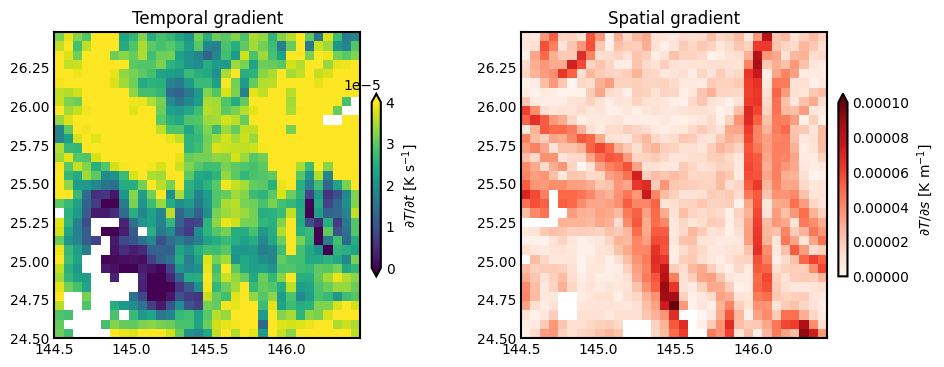

In [17]:
fig, ax = plots.plot_gradients(ds)

# Using the de Kreij code to make a GP prediction

***Note: this is using assumed parameters***

Adapted from this example:
https://github.com/rdkreij/inversion-sst-gp/blob/main/4_satellite_application/4_1_case_1_rossby_number.py

`predict_scene` has the option to output the full posterior covariance matrix (this is not saved for `predict_series`)

In [18]:
# Get an initial guess
guess_params = gpr.get_default_params()['initial_params']

print("Calculating GP regression prediction")
ds_guess, Kpp_guess = gpr.predict_scene(ds.isel(time=0), guess_params, return_cov=True, return_prior=True)

Calculating GP regression prediction


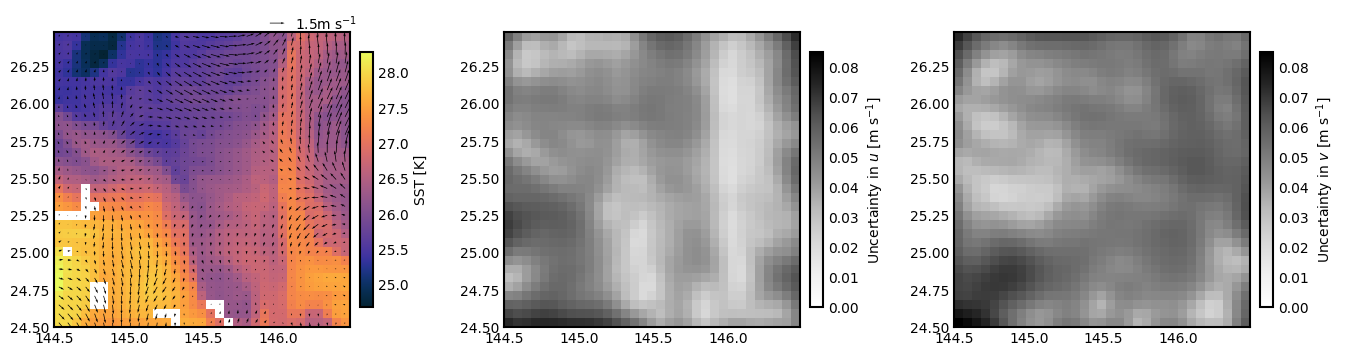

In [19]:
# Plot the GP posterior mean estimation
fig, ax = plots.plot_prediction(ds_guess, qk_size=1.5, qv_scale=30)

---
# Run the parameter optimization

***Here we fit the hyper-parameters to get the best predictions***

In [22]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

ds_results = gpr.fit_scene(ds, prop_sat, callback='on')
ds_results

Running GP optimization
sigma_u       l_u           tau_u         sigma_v       l_v           tau_v         sigma_S       l_S           tau_S         sigma_tau     lml        
0.09          3e+04         0.01          0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          5196.8     
0.09          3e+04         0.01          0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          5196.8     
0.09          3e+04         0.01          0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          5196.8     
0.09          3e+04         0.01          0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          5196.8     
0.09          3e+04         0.01          0.09          3e+04         0.01          3e-07         2e+04         2e-07         0.01          5196.8     
0.09          3e+04         0.01          0.09          3e+04   

<xarray.Dataset> Size: 88B
Dimensions:    (time: 1)
Coordinates:
  * time       (time) datetime64[s] 8B 2025-05-12
Data variables:
    sigma_u    (time) float64 8B 0.222
    l_u        (time) float64 8B 1.24e+04
    tau_u      (time) float64 8B 0.01005
    sigma_v    (time) float64 8B 0.222
    l_v        (time) float64 8B 1.24e+04
    tau_v      (time) float64 8B 0.01005
    sigma_S    (time) float64 8B 1.187e-05
    l_S        (time) float64 8B 2.391e+04
    tau_S      (time) float64 8B 6.98e-07
    sigma_tau  (time) float64 8B 0.009625

In [23]:
print("Calculating GP regression prediction")
ds_prediction, Kpp_posterior = gpr.predict_scene(ds.isel(time=0), ds_results, return_prior=True, return_cov=True)

Calculating GP regression prediction


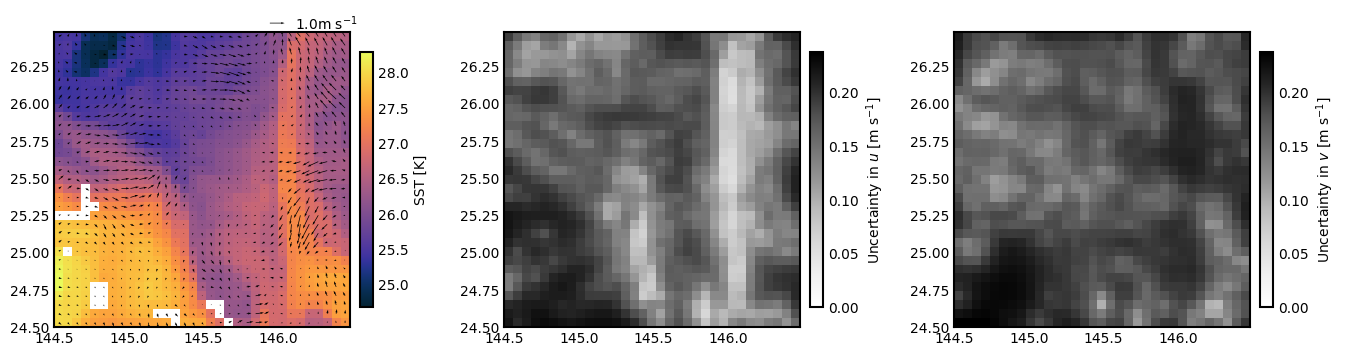

In [24]:
fig, ax = plots.plot_prediction(ds_prediction)

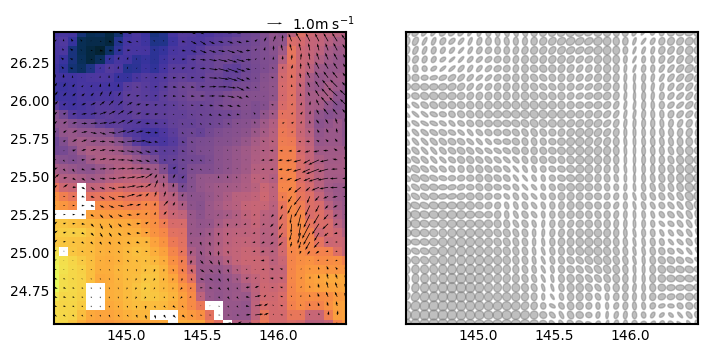

In [31]:
fig, ax = plots.plot_pred_ellipses(ds_prediction, Kpp_posterior, scale=7, color='grey', alpha=0.5, an=False)

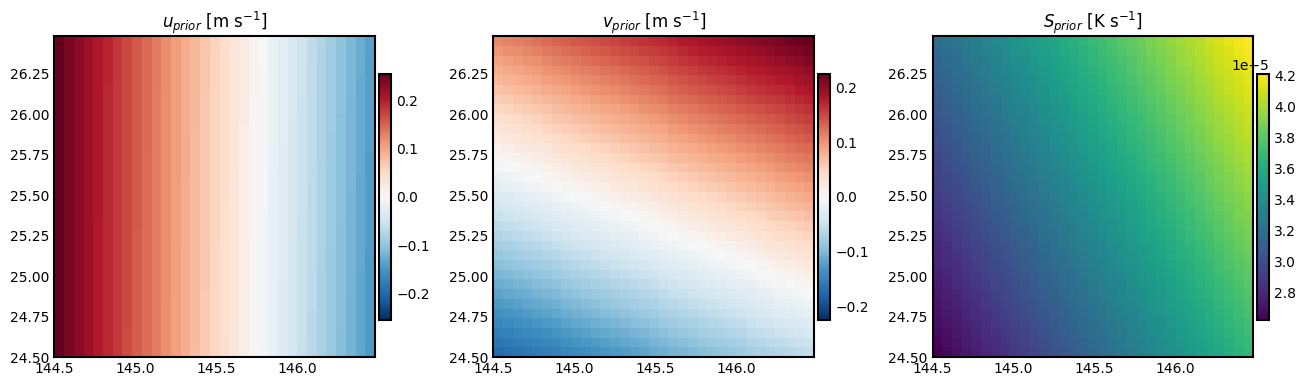

In [ ]:
fig, ax = plots.plot_mean_function(ds_prediction)

## Simulate particles in the flow field

### Under construction !!!

In [ ]:
# from inversion_sst_gp.simulation.particle_tracking import simulate_flow_fields, simulate_particle_multi_flow_fields

# def simulate_particles_ds(ds, Kpp, lon_start, lat_start, n_samples=1, tstep=3600, Nstep=3*24):
    
#     us, vs = simulate_flow_fields(Kpp, ds['mu_u'].values, ds['mu_v'].values, ds['X'].values.shape[1], ds['X'].values.shape[0], n_sample=n_samples)
    
#     lons, lats = simulate_particle_multi_flow_fields(ds['X'].values, ds['Y'].values,\
#                                                      us, vs,\
#                                                      lon_start, lat_start,\
#                                                      lon_start, lat_start,\
#                                                      tstep, Nstep)
    
#     return lons, lats

In [ ]:
# Kpp = Kpp_posterior  # shape (n, n, 2, 2)
# n = Kpp.shape[0]
# K_full = Kpp.transpose(0, 2, 1, 3).reshape(n*2, n*2)
# K_full = np.kron(K_full, np.zeros(n, n))
# K_full.shape

In [ ]:
# lon_drift, lat_drift = simulate_particles_ds(ds_prediction, Kpp_posterior, 145, 25, n_samples=10)

## Compare to Copernicus re-analysis

In [33]:
import copernicusmarine

cp_obj = copernicusmarine.subset(
                dataset_id='cmems_mod_glo_phy_my_0.083deg_P1D-m',
                variables=['uo', 'vo'],
                minimum_longitude=LON_LIMITS[0],
                maximum_longitude=LON_LIMITS[1],
                minimum_latitude=LAT_LIMITS[0],
                maximum_latitude=LAT_LIMITS[1],
                start_datetime=time_str[:10],
                end_datetime=time_str[:10],
                minimum_depth=0.5,
                maximum_depth=0.5,
                output_filename='cmems_currents_himawari_01',
                output_directory=data_dir,
                netcdf3_compatible=True
)

INFO - 2026-02-11T01:25:37Z - Selected dataset version: "202311"
INFO - 2026-02-11T01:25:37Z - Selected dataset part: "default"


In [34]:
save_path = cp_obj.file_path.as_posix() 
ds_cmems = xr.open_dataset(save_path)
ds_cmems

<xarray.Dataset> Size: 10kB
Dimensions:    (time: 1, depth: 1, latitude: 25, longitude: 25)
Coordinates:
  * time       (time) datetime64[ns] 8B 2025-05-12
  * depth      (depth) float32 4B 0.494
  * latitude   (latitude) float32 100B 24.5 24.58 24.67 ... 26.33 26.42 26.5
  * longitude  (longitude) float32 100B 144.5 144.6 144.7 ... 146.3 146.4 146.5
Data variables:
    uo         (time, depth, latitude, longitude) float64 5kB ...
    vo         (time, depth, latitude, longitude) float64 5kB ...
Attributes: (12/25)
    Conventions:               CF-1.4
    bulletin_date:             2021-07-07 00:00:00
    bulletin_type:             operational
    comment:                   CMEMS product
    domain_name:               GL12
    easting:                   longitude
    ...                        ...
    references:                http://www.mercator-ocean.fr
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    z_max:                     5727.9169921875
    z_min:                     0.49402499198913574
    copernicusmarine_version:  2.3.0

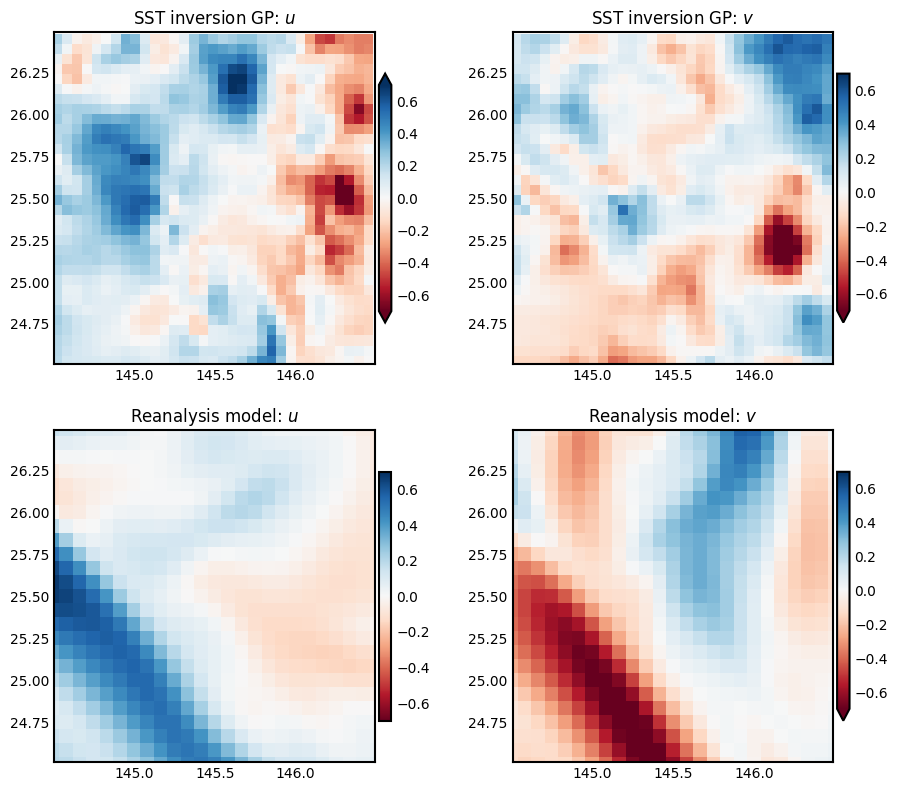

In [35]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

vmm = 0.7
cmap = 'RdBu'
cbar_kw = {'pad':0.01, 'label':'', 'shrink':0.75}
ds_prediction['mu_u'].plot(ax=ax[0][0], vmin=-vmm, vmax=vmm, cmap=cmap, cbar_kwargs=cbar_kw)
ds_prediction['mu_v'].plot(ax=ax[0][1], vmin=-vmm, vmax=vmm, cmap=cmap, cbar_kwargs=cbar_kw)
ax[0][0].set_title('SST inversion GP: $u$')
ax[0][1].set_title('SST inversion GP: $v$')

ds_cmems['uo'].squeeze().plot(ax=ax[1][0], vmin=-vmm, vmax=vmm, cmap=cmap, cbar_kwargs=cbar_kw)
ds_cmems['vo'].squeeze().plot(ax=ax[1][1], vmin=-vmm, vmax=vmm, cmap=cmap, cbar_kwargs=cbar_kw)
ax[1][0].set_title('Reanalysis model: $u$')
ax[1][1].set_title('Reanalysis model: $v$')

for x in ax.flatten():
    x.set_xlabel('')
    x.set_ylabel('')
    x.set_xlim(144.51, 146.49)
    x.set_ylim(24.51, 26.49)